#CAR LICENSE PLATE DETECTION

I developed a car license plate detection model using YOLO (You Only Look Once), a real-time object detection algorithm. The model accurately identifies and localizes license plates in images. It is designed for applications such as automated parking systems and traffic monitoring.
I used a dataset containing annotated images of vehicles with visible license plates, including variations in lighting, angles, and backgrounds, to train the YOLO model for robust detection.
We can use Roboflow https://app.roboflow.com/ to annote the images and prepare the data for training the YOLO model.But here i have used a Kaggle dataset of vehicle images which has .xml files with visible license plates and there x and y coordinates.

# Import all Modules

## YOLO: A Brief History
1. YOLO (You Only Look Once), a popular object detection and image segmentation model, was developed by Joseph Redmon and Ali Farhadi at the University of Washington. Launched in 2015, YOLO quickly gained popularity for its high speed and accuracy.

2. YOLOv2, released in 2016, improved the original model by incorporating batch normalization, anchor boxes, and dimension clusters.
3. YOLOv3, launched in 2018, further enhanced the model's performance using a more efficient backbone network, multiple anchors and spatial pyramid pooling.
4. YOLOv4 was released in 2020, introducing innovations like Mosaic data augmentation, a new anchor-free detection head, and a new loss function.
5. YOLOv5 further improved the model's performance and added new features such as hyperparameter optimization, integrated experiment tracking and automatic export to popular export formats.
6. YOLOv6 was open-sourced by Meituan in 2022 and is in use in many of the company's autonomous delivery robots.
7. YOLOv7 added additional tasks such as pose estimation on the COCO keypoints dataset.
8. YOLOv8 is the latest version of YOLO by Ultralytics. As a cutting-edge, state-of-the-art (SOTA) model, YOLOv8 builds on the success of previous versions, introducing new features and improvements for enhanced performance, flexibility, and efficiency. YOLOv8 supports a full range of vision AI tasks, including detection, segmentation, pose estimation, tracking, and classification. This versatility allows users to leverage YOLOv8's capabilities across diverse applications and domains.
9. YOLOv9 Introduces innovative methods like Programmable Gradient Information (PGI) and the Generalized Efficient Layer Aggregation Network (GELAN).

In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split



import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


# Check if Cuda is Available

In [ ]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.7/901.7 kB 16.8 MB/s eta 0:00:00


In [ ]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


# Setting up the dataset paths

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"vchetana","key":"e581bb7783bf7e1d7809f4f35a898767"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!ls dataset


ls: cannot access 'dataset': No such file or directory


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/andrewmvd/car-plate-detection")


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection


100%|██████████| 203M/203M [00:02<00:00, 82.9MB/s]


In [ ]:
dataset_path="/content/car-plate-detection"

In [ ]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)

    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

# Example usage
print(the_number_in_the_string("file123.txt"))  # Output: 123
print(the_number_in_the_string("no_numbers_here"))  # Output: 0

123
0


# Formatting the XML File and creating DF

In [ ]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob

# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()

    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/car-plate-detection/images/Cars0.png,226,419,125,173,500,268
1,/content/car-plate-detection/images/Cars1.png,134,262,128,160,400,248
2,/content/car-plate-detection/images/Cars2.png,229,270,176,193,400,400
3,/content/car-plate-detection/images/Cars3.png,142,261,128,157,400,225
4,/content/car-plate-detection/images/Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/content/car-plate-detection/images/Cars428.png,142,258,128,157,400,225
429,/content/car-plate-detection/images/Cars429.png,86,208,166,195,301,400
430,/content/car-plate-detection/images/Cars430.png,38,116,159,197,400,225
431,/content/car-plate-detection/images/Cars431.png,55,343,82,147,400,192


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [ ]:
import os
import shutil
import pandas as pd

# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [ ]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,/content/car-plate-detection/images/Cars124.png,305,320,256,267,400,267
315,/content/car-plate-detection/images/Cars315.png,12,385,98,181,400,300
282,/content/car-plate-detection/images/Cars282.png,37,319,145,203,350,263
236,/content/car-plate-detection/images/Cars236.png,223,250,106,119,400,176
112,/content/car-plate-detection/images/Cars112.png,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,/content/car-plate-detection/images/Cars110.png,286,328,133,159,400,267
255,/content/car-plate-detection/images/Cars255.png,116,273,156,188,400,267
292,/content/car-plate-detection/images/Cars292.png,91,137,187,208,400,267
54,/content/car-plate-detection/images/Cars54.png,148,257,61,118,400,300


In [ ]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)

    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [ ]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [ ]:
os.getcwd()

'/content'

![image.png](attachment:00956efa-22a1-49e2-b986-52c97b903c36.png)

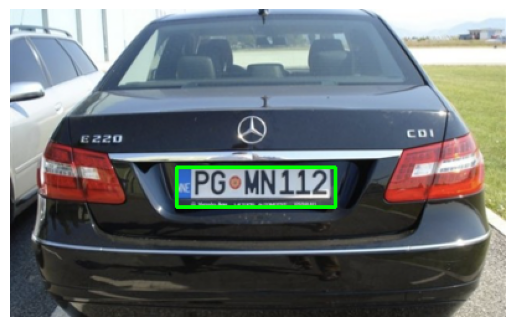

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [ ]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.9MB/s]


In [ ]:
model.train(
    data='datasets.yaml',  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=16,              # Batch size
    device='cuda',         # Use GPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 13.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.1MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 666.72it/s]

train: New cache created: /content/datasets/cars_license_plate_new/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:08<00:00, 40.66it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 336.84it/s]

val: New cache created: /content/datasets/cars_license_plate_new/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 83.44it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.663G      1.803      2.961      1.362         19        320: 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         44         44    0.00382      0.909      0.395      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.614G       1.51      1.625      1.123         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         44         44      0.764     0.0747      0.383      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.623G      1.559      1.425      1.168         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]

                   all         44         44      0.441     0.0909      0.212     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.617G      1.583      1.394      1.241         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         44         44      0.648      0.477      0.517      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.617G      1.524      1.283      1.182         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

                   all         44         44      0.566      0.273      0.284       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.617G      1.521      1.232      1.192         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         44         44      0.642      0.523      0.557      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.617G      1.453      1.169      1.172         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         44         44      0.768      0.753      0.792      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.617G      1.448      1.113      1.147         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]

                   all         44         44      0.788      0.795        0.8      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.617G      1.392      1.094      1.141         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

                   all         44         44       0.71      0.836       0.76      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.617G      1.382      1.038       1.14         18        320: 100%|██████████| 22/22 [00:05<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         44         44      0.785      0.818       0.83      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.617G      1.332          1      1.112         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


                   all         44         44       0.79      0.682      0.761      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.617G      1.414     0.9884      1.137         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]

                   all         44         44      0.788      0.845      0.834      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.614G      1.442     0.9792      1.141         15        320: 100%|██████████| 22/22 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]

                   all         44         44      0.845      0.841      0.852      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.617G      1.374     0.9688      1.138         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         44         44      0.769       0.83      0.842      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.617G      1.346     0.9359      1.105         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44      0.845      0.869      0.897      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.617G      1.316     0.8798      1.113         13        320: 100%|██████████| 22/22 [00:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]

                   all         44         44      0.811      0.881      0.865      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.614G      1.245     0.8698      1.079         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all         44         44      0.774      0.795      0.812       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.617G      1.257     0.8297      1.073         21        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         44         44      0.829      0.773      0.815      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.614G      1.264     0.8035      1.084         17        320: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]

                   all         44         44      0.799      0.795      0.855      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.617G      1.279     0.8359      1.088         24        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]


                   all         44         44      0.832      0.841      0.865       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.617G      1.257     0.8213      1.091         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         44         44      0.918       0.76      0.875      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.617G      1.251     0.8288      1.084         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

                   all         44         44      0.935      0.841      0.911      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.617G      1.298     0.8446       1.08         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

                   all         44         44      0.865      0.878      0.903      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.617G      1.191     0.7889      1.065         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]

                   all         44         44      0.906      0.874      0.913      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.617G      1.195      0.785      1.044         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]

                   all         44         44      0.925      0.837       0.87      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.614G      1.232     0.7656      1.081         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         44         44      0.916      0.841      0.878      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.617G      1.169     0.7425      1.056         18        320: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]

                   all         44         44      0.903      0.864      0.884      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.617G      1.135     0.7134      1.029         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

                   all         44         44      0.874      0.786      0.816      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.617G       1.12     0.7227      1.042         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

                   all         44         44      0.812      0.886      0.845      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.617G      1.156     0.7168      1.044         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

                   all         44         44       0.93      0.909      0.928      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.617G       1.13     0.7083       1.04         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

                   all         44         44      0.879      0.822      0.885      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.617G      1.127     0.7025      1.043         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]

                   all         44         44      0.907      0.886      0.881      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.617G      1.212     0.7443      1.057         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


                   all         44         44      0.863      0.818      0.859      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.617G      1.077     0.6978      1.022         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         44         44          1      0.816      0.886      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.614G      1.071     0.6697       1.02         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         44         44      0.887      0.891      0.898       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.617G      1.089     0.6927      1.022         19        320: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]


                   all         44         44      0.941      0.841      0.936      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.617G      1.105     0.6921      1.021         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

                   all         44         44      0.922      0.864      0.921      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.617G      1.081     0.6631      1.011         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]


                   all         44         44      0.825      0.886       0.91      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.617G      1.039     0.6532      1.006         20        320: 100%|██████████| 22/22 [00:03<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         44         44      0.922      0.808      0.885      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.617G      1.024     0.6218     0.9937         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]


                   all         44         44      0.947      0.795       0.89      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.617G      1.057     0.6535      1.011         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]

                   all         44         44      0.935      0.795      0.876      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.617G     0.9973     0.6178      1.002         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         44         44      0.896      0.773      0.854      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.617G      1.033     0.6258      1.007         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         44         44      0.811      0.876      0.866      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.617G       1.06      0.636     0.9938         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


                   all         44         44      0.915      0.795      0.873      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.614G      1.049     0.6281     0.9867         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         44         44       0.92      0.818      0.905      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.617G      1.064     0.6459      1.004         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]

                   all         44         44      0.875      0.841      0.886      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.617G      1.021     0.6199     0.9884         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         44         44      0.934      0.841      0.906        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.614G     0.9682     0.5953     0.9676         13        320: 100%|██████████| 22/22 [00:03<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]


                   all         44         44      0.934      0.818      0.887      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.617G     0.9593     0.5778     0.9698         12        320: 100%|██████████| 22/22 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]

                   all         44         44      0.918      0.767      0.851      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.617G      1.022     0.6169     0.9824         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]

                   all         44         44      0.838      0.864      0.905      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.617G      1.015     0.6198          1         18        320: 100%|██████████| 22/22 [00:02<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.08it/s]

                   all         44         44      0.833      0.904      0.889      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.617G      1.018     0.5967     0.9942         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]

                   all         44         44      0.898      0.797       0.87      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.617G     0.9662      0.581     0.9533         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]

                   all         44         44      0.944      0.818      0.895       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.617G     0.9793     0.5762     0.9814         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]

                   all         44         44      0.919      0.778      0.867       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.614G     0.9561     0.5811     0.9767         10        320: 100%|██████████| 22/22 [00:02<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


                   all         44         44      0.878      0.818      0.888      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.617G     0.9283     0.5774     0.9584         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

                   all         44         44      0.885      0.877       0.92      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.614G     0.9162     0.5656     0.9593         14        320: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         44         44      0.918      0.864      0.922      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.617G     0.9503     0.5873     0.9562         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]

                   all         44         44      0.907      0.864      0.921      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.614G     0.9468     0.5595      0.965         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.81it/s]

                   all         44         44      0.941      0.864      0.927      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.617G     0.9399     0.5698     0.9835         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         44         44       0.89      0.918      0.925      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.617G     0.9395     0.5637     0.9783         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


                   all         44         44      0.866      0.909      0.914      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.617G      0.893     0.5455     0.9602         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.00it/s]

                   all         44         44      0.849      0.864      0.914      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.617G     0.8745     0.5376     0.9582          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.11it/s]


                   all         44         44      0.902      0.836      0.904      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.617G     0.8797     0.5497     0.9517         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]

                   all         44         44      0.924      0.831      0.887      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.617G     0.9009     0.5498     0.9466         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         44         44      0.922       0.81        0.9        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.617G     0.8766     0.5357     0.9406         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         44         44       0.91      0.818      0.914       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.614G     0.8935     0.5455     0.9439         11        320: 100%|██████████| 22/22 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]

                   all         44         44      0.905      0.818       0.91      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.617G     0.8603     0.5281     0.9275         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


                   all         44         44      0.872      0.841        0.9      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.617G     0.8224     0.5047     0.9452         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         44         44      0.943      0.795      0.903      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.617G     0.8364     0.4891     0.9448         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         44         44      0.945      0.784      0.901      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.617G     0.8623     0.5171     0.9316         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


                   all         44         44      0.945      0.785        0.9      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.617G     0.8577     0.5067     0.9462         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]

                   all         44         44      0.912      0.818      0.889      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.617G      0.883     0.5093     0.9284         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         44         44      0.938      0.818      0.898      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.614G     0.8678     0.5126     0.9331         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         44         44      0.934      0.818      0.889      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.614G     0.8452      0.505      0.951         11        320: 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]

                   all         44         44      0.943      0.795      0.887      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.617G     0.8097     0.4982     0.9354         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         44         44      0.973      0.808      0.886      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.617G     0.8023     0.4744     0.9223         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         44         44      0.957      0.795      0.891      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.617G     0.8351     0.4967     0.9347         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]

                   all         44         44      0.895      0.773      0.887      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.617G     0.8134     0.4816     0.9304         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         44         44      0.907      0.773      0.884      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.617G     0.8226     0.5153     0.9344         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


                   all         44         44      0.919      0.771       0.89      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.617G     0.7901      0.487     0.9257         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         44         44      0.918      0.795      0.897      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.617G     0.8203     0.4867      0.924         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.00it/s]

                   all         44         44      0.894      0.818      0.898      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.617G     0.7871     0.4711      0.929         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]

                   all         44         44      0.922      0.818      0.899      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.617G     0.7662     0.4766     0.9045         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         44         44      0.923      0.813      0.889      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.614G     0.8096     0.4769      0.925         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         44         44      0.921      0.795       0.89      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.614G     0.7749     0.4803     0.9227         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.34it/s]

                   all         44         44      0.938      0.795      0.899      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.617G     0.7482     0.4639     0.9021         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


                   all         44         44      0.942      0.795      0.894      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.617G     0.7536     0.4592     0.9253         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]

                   all         44         44      0.921      0.795      0.896      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.614G     0.7605     0.4535     0.9166         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

                   all         44         44       0.96      0.795      0.901      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.614G     0.7443     0.4517     0.9202         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.10it/s]

                   all         44         44      0.957      0.795      0.899      0.543


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.614G     0.9948     0.5383       1.01          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


                   all         44         44      0.941      0.795      0.887      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.617G     0.9933      0.528      1.032          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         44         44      0.956      0.795      0.895      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.614G     0.9373     0.5077      1.004          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]

                   all         44         44       0.96      0.795      0.892      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.617G     0.9609     0.5038     0.9947          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         44         44      0.833      0.906      0.926       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.614G     0.9619     0.4957       1.01          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         44         44      0.963      0.773      0.922      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.617G     0.9543     0.5113      1.005          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


                   all         44         44      0.962      0.773      0.921      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.614G     0.9292     0.4682     0.9943          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]

                   all         44         44       0.96      0.773      0.904      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.614G     0.9168     0.4918     0.9803          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]

                   all         44         44      0.959      0.773      0.906      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.614G     0.9087     0.4728     0.9914          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.959      0.773      0.908      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.614G     0.8804     0.4816     0.9711          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


                   all         44         44      0.958      0.773      0.891      0.568

100 epochs completed in 0.113 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


                   all         44         44      0.894      0.818      0.898      0.568
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b0a0c8297e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

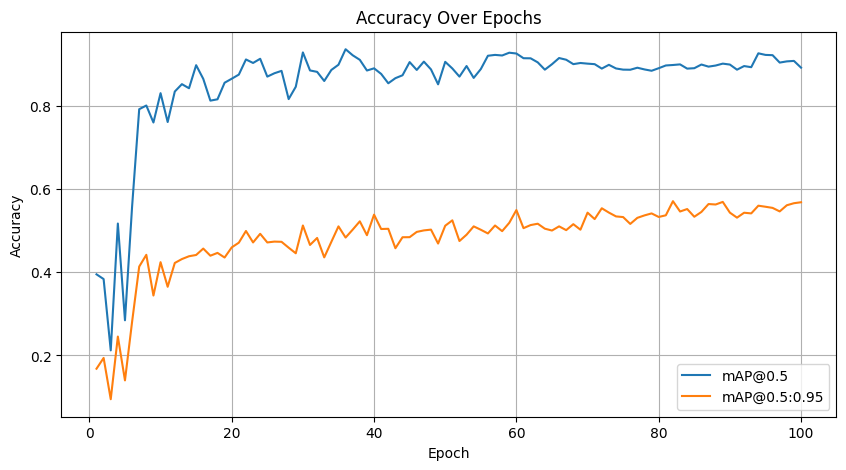

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /content/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 41.8ms
Speed: 1.0ms preprocess, 41.8ms inference, 19.3ms postprocess per image at shape (1, 3, 160, 320)


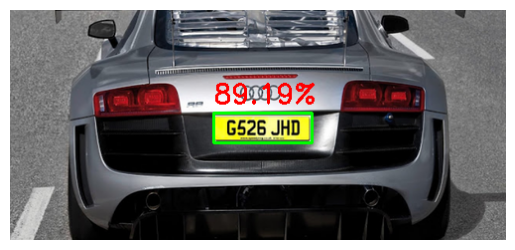

In [ ]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /content/car-plate-detection/images/Cars75.png: 224x320 (no detections), 46.7ms
Speed: 0.8ms preprocess, 46.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 320)


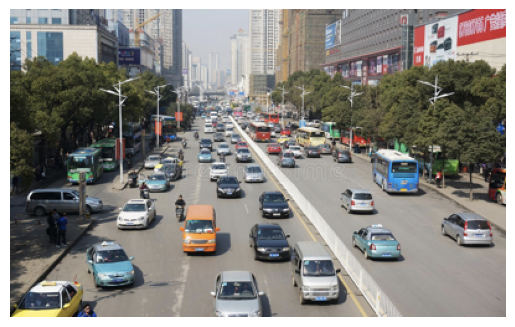

In [ ]:
predict_and_plot(test.iloc[1].img_path)


image 1/1 /content/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 40.0ms
Speed: 0.8ms preprocess, 40.0ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 192)


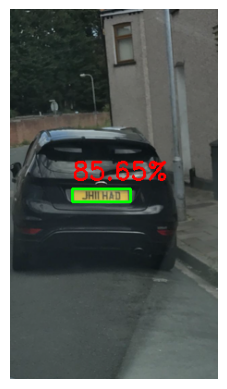

In [ ]:
predict_and_plot(test.iloc[2].img_path)

In [ ]:
test.shape

(44, 7)


image 1/1 /content/car-plate-detection/images/Cars364.png: 224x320 1 license_plate, 40.8ms
Speed: 0.9ms preprocess, 40.8ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


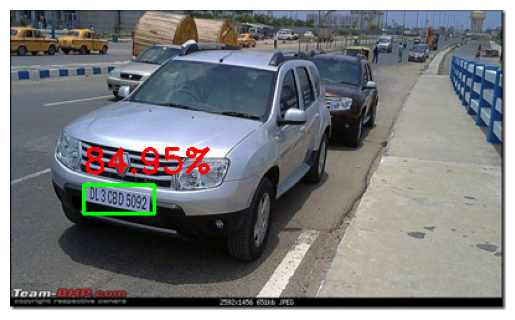

In [ ]:
predict_and_plot(test.iloc[4].img_path)

#Testing on new image

# Implementing Text Extraction

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:

!pip install pytesseract


In [ ]:
import pytesseract
from pytesseract import Output


image 1/1 /content/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 52.5ms
Speed: 1.0ms preprocess, 52.5ms inference, 1.1ms postprocess per image at shape (1, 3, 160, 320)


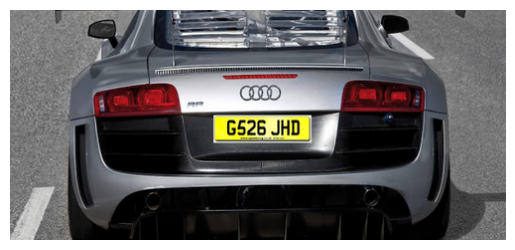

In [ ]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()
predict_and_plot(test.iloc[0].img_path)

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
from pytesseract import Output


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image

In [ ]:
test.iloc[0].img_path

'/content/car-plate-detection/images/Cars425.png'

In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,517 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restrict


image 1/1 /content/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 33.6ms
Speed: 0.8ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 320)
Detected text: -G526 JHD |



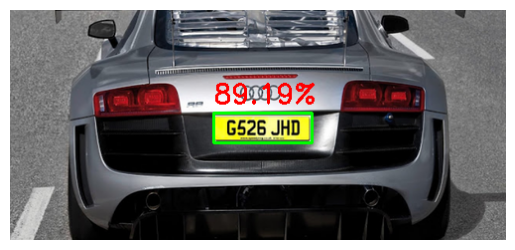

In [ ]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /content/car-plate-detection/images/Cars75.png: 224x320 (no detections), 41.9ms
Speed: 0.9ms preprocess, 41.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 320)


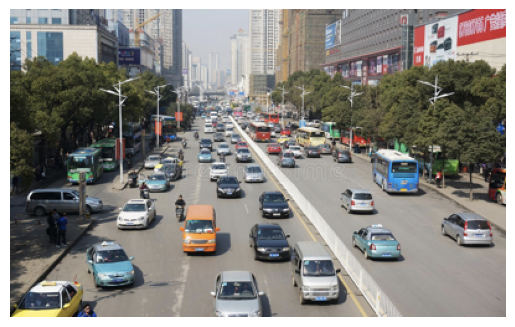

In [ ]:
predict_and_plot(test.iloc[1].img_path)


image 1/1 /content/car-plate-detection/images/Cars364.png: 224x320 1 license_plate, 65.1ms
Speed: 1.1ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
Detected text: a3 tap 5090)



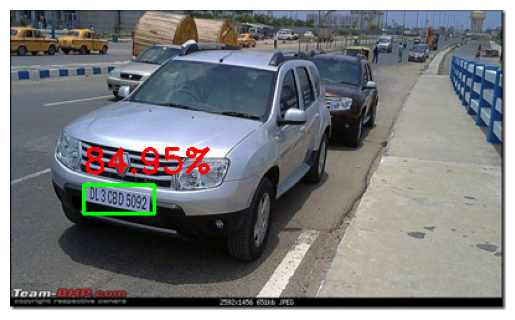

In [ ]:
predict_and_plot(test.iloc[4].img_path)


image 1/1 /content/car-plate-detection/images/Cars154.png: 320x256 1 license_plate, 79.9ms
Speed: 1.3ms preprocess, 79.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 256)
Detected text: q thos 2662



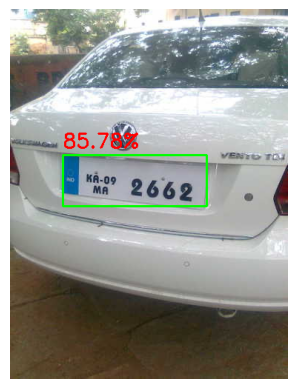

In [ ]:
predict_and_plot(test.iloc[41].img_path)